In [14]:
import numpy as np
import scipy
from scipy.stats import qmc, norm
import copy
import matplotlib.pyplot as plt
from scipy.stats import norm
def test_simulator():
    """Use this function to test 'simulator' and 'evaluate' functions"""

    alpha_test = 0.5
    V_0_test = 25.0
    x_target = 24.0
    #score, x_path, y_path = simulator(alpha=alpha_test, V_0=V_0_test, x_target=x_target)
    score, x_path, y_path = simulator(alpha=alpha_test, V_0=V_0_test) # you don't have to specify x_target

    plt.figure(figsize=(8,6))
    plt.plot(x_path, y_path, ".-", label="Ball Path")
    plt.scatter([0.], [0.], marker="o", s=200, label="Start")
    plt.scatter([x_target], [0.], marker="X", s=200, label="Target")
    plt.gca().set_xlabel("X")
    plt.gca().set_xlabel("Y")
    plt.gca().set_title(f"Score: {score}")
    plt.legend()
    plt.show()

    # the function 'evaluate' can be used to compute the output score for multiple inputs (alpha_i, V_0_i)
    X_scaled = np.array([[alpha_test, V_0_test]])
    Y = evaluate(X_scaled)    
    print("X_scaled:", X_scaled)
    print("Y:", Y)

    X_scaled = np.array([[0.3, 10.], [0.5, 15.], [0.7, 20]])
    Y = evaluate(X_scaled)
    print("X_scaled:", X_scaled)
    print("Y:", Y)

In [15]:
def simulator(    
    alpha: float = 0.785, 
    V_0: float = 5., 
    v_wind: float = -1.5, 
    x_target: float = 24.0, 
    dt: float = 1e-04, 
    t_max: float = 10., 
    c_d: float = 0.54, 
    c_d_var: float = 0.1,   # noise on the output. You can change this to 0 (no noise)
    A_ref: float = 0.045, 
    rho: float = 1.225, 
    m: float = 0.6, 
    g: float = 9.81
    ):
    """
    This function computes the path of one ball with the parameters alpha and V_0
    The other parameters don't need to be set.

    call it as 'f(alpha, V_0)'

    input parameters:
        - alpha:    ball throwing angle
        - V_0:      initial velocity of the ball

    returns:
        - obj_f:    squared distance to the target
        - x[:i+1]:  x postions of the ball at all timesteps before it hits the ground  
        - y[:i+1]:  y postions of the ball at all timesteps before it hits the ground  
    """
    
    # make sure the input has the right values
    assert dt >= 1e-06, "choose a bigger dt"
    assert dt <= 1e-02, "choose a smaller dt"
    assert alpha >= 0., "choose a bigger alpha"
    assert alpha <= np.pi, "choose a smaller alpha"
    assert V_0 >= 0., "choose a bigger V_0"
    assert V_0 <= 200., "choose a smaller V_0"
    
    N_steps = int(np.ceil(t_max / dt)) + 10
    #print(N_steps)
    x = np.empty(N_steps)
    y = np.empty(N_steps)
    v_x = np.empty(N_steps)
    v_y = np.empty(N_steps)
    a_x = np.empty(N_steps)
    a_y = np.empty(N_steps)       
    
    # initial conditions
    x[0] = 0.
    y[0] = 0.
    v_x[0] = V_0*np.cos(alpha)
    v_y[0] = V_0*np.sin(alpha)
    a_x[0] = 0.
    a_y[0] = 0.
    
    i = 0
    
    while i < N_steps - 10:
        v_mag = np.sqrt((v_x[i] - v_wind)**2 + v_y[i]**2)
        F_w_x = -0.5*rho*A_ref*v_mag*(v_x[i] - v_wind)*c_d*np.exp(np.random.normal(0, c_d_var))
        F_w_y = -0.5*rho*A_ref*v_mag*(v_y[i])*c_d*np.exp(np.random.normal(0, c_d_var))
        a_x[i+1] = F_w_x/m
        a_y[i+1] = F_w_y/m - g
        v_x[i+1] = v_x[i] + a_x[i+1]*dt
        v_y[i+1] = v_y[i] + a_y[i+1]*dt
        x[i+1] = x[i] + v_x[i+1]*dt
        y[i+1] = y[i] + v_y[i+1]*dt
        
        #print(F_w_x, F_w_y, x[i+1], y[i+1])
        i = i + 1
        
        if y[i] <= -1.e-06 and v_y[i] < 0.:
            break
                    
    
    obj_f = np.min([(x[i] - x_target)**2, (x[i-1] - x_target)**2])
    
    return obj_f, x[:i+1], y[:i+1]

In [16]:
def evaluate(X, **kwargs):
    """
    This function can be used to compute the output of simulator for a vector of multiple input settings (alpha, V_0)
    """
    n_samples, n_dim = X.shape
    
    n = np.sum([1 for _, v in kwargs.items() if v==True])
    if n == 0 and n_dim == 1:
        kwargs = {"alpha": True}
    elif n == 0 and n_dim == 2:
        kwargs = {"alpha": True, "V_0": True}
    elif n == n_dim:
        #print("okay")
        pass
    else:
        raise Exception("bad input -", "n_dim:", n_dim, " n:", n)
    
    F = np.empty(n_samples)
    for i in range(n_samples):
        sim_kwargs = {}
        for j, (k, v) in enumerate(kwargs.items()):
            if type(v) == float:
                sim_kwargs[k] = v
            elif v:
                sim_kwargs[k] = X[i,j]
        f, _, _ = simulator(**sim_kwargs)
        F[i] = f
    
    return F[:,np.newaxis]

In [17]:
num = 10
x_alfa = np.array([np.linspace(0, 1.5, num)])
x_vel = np.array([np.linspace(5, 40, num)])
x_input = np.concatenate([x_alfa.T,x_vel.T ], axis=1)
X_ = []
for i in range(num):
    for j in range(num):
        X_.append([x_input[i,0],x_input[j,1]])
X_base =np.array(X_)
Y_base = evaluate(X_base)

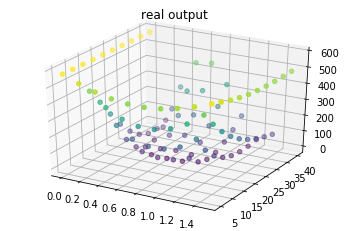

In [18]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
zdata = Y_base[:,0]
xdata = X_base[:,0]
ydata = X_base[:,1]
ax.scatter3D(xdata, ydata, zdata, c=zdata);
ax.set_title('real output');

In [239]:
np.min(Y_base), X_base[np.argmin(Y_base)]

(0.09277430123811997, array([ 1.        , 24.44444444]))

In [19]:
from numpy import random
def get_doe_samples(num_doe_points=30):
    """
    Get a number of DoE (Design of Experiment) samples
    
    """

    v0 = np.array([np.random.rand(num_doe_points)])
    alfa = np.array([np.random.rand(num_doe_points)])
    X = np.concatenate([alfa,v0 ], axis=0)

    X = X.T
    return X

In [20]:
def scale_input(X, alpha_min=0.15, alpha_max=1.5, V_0_min=5., V_0_max=40.):
    """
    Scale the input from values in [0, 1) to [alpha_min, alpha_max) and [V_0_min, V_0_max)
    """

    X_scaled = np.copy(X)
    X_scaled[:,0] = X_scaled[:,0]*(alpha_max - alpha_min) + alpha_min
    X_scaled[:,1] = X_scaled[:,1]*(V_0_max - V_0_min) + V_0_min

    return X_scaled

In [32]:
class RBF_Kernel:
    """
    This class can be used organize the functions related to the kernel.
    """

    def __init__(self, ndim=2, logTheta=0, logRegPara=None) -> None:
        """
        Initialize the class parameters.
        Theta and the regularization parameter are stored as their log-value
        """

        self.ndim = ndim
        self.logTheta = logTheta
        self.logRegPara = logRegPara
        self.presolved = False

        self.variance = 0.1
    def get_theta(self):
        """
        Getter for theta
        """
        return np.power(10, self.logTheta)
    
    def get_regPara(self):
        """
        Getter for the regularization parameter
        """
        return np.power(10, self.logRegPara)
    
    def kernel_func(self, x1, x2, theta, regPara, p=2):
        """
        Compute the kernel function between two (2D) points x1 and x2
        """

        if type(x1) is np.ndarray:        
            assert len(x1) == len(theta)
            assert type(x2) is np.ndarray
            assert x1.shape == x2.shape

            d = len(x1) # dimesionality of the input x
            cor = np.sum( [ float(theta[i]) * np.power( float(x1[i]-x2[i]), p ) for i in range(d) ] )
        else:
            assert type(x1) is float
            assert type(theta) is float
            d = 1
            cor = float(theta) * np.power( float(x1-x2), p )
        
        cor = np.exp(-float(cor))
        
        return cor

    def get_correlation_matrix(self, x, logTheta=1., logRegPara=None):
        """
        Returns the full covariance matrix of input data x
        """
        # reg has to be None or float.

        theta = np.power(10, logTheta)
        if logRegPara is not None:
            regPara = np.power(10, logRegPara)
        else:
            regPara = 0

        N,D = x.shape

        K = np.empty((N, N), dtype=np.float64)
        for i in range(N):
            for j in range(N):
                K[i,j] = self.kernel_func(x[i], x[j], theta, regPara)
            K[i,i] += regPara

        return K
    
    def set_hyperparameters(self, hyperparameters, regularization, log=True):
        """
        Setter for theta and the regularization parameter.
        log=True if the hyperparameters are given as logs
        """

        if log:
            if regularization:
                self.logTheta   = hyperparameters[:-1]
                self.logRegPara = hyperparameters[-1]     # order to define this first
                
            else:
                self.logTheta = hyperparameters
                self.logRegPara = None
        else:
            if regularization:
                self.logTheta = np.log10(hyperparameters[:-1])
                self.logRegPara = np.log10(hyperparameters[-1])     # order to define this first
            else:
                self.logTheta = np.log10(hyperparameters)
                self.logRegPara = None
        
        self.regularization = regularization

        self.presolved = False
    
    def get_hyperparameters(self, log=True):
        """
        Getter for theta and the regularization parameter.
        log=True if the hyperparameters should be given as logs
        """
        hyperparameters = np.atleast_1d(self.logTheta)
        if self.regularization:
            hyperparameters = np.concatenate((hyperparameters, np.atleast_1d(self.logRegPara)))        
        if not log:
            hyperparameters = np.power(10, hyperparameters)
        
        return hyperparameters


    def calculate_likelihood(self, X, Y):
        """
        This function is supposed to calculate the log-likelihood (without the constant terms) of the data y at position(s) x 
        """
        # N: sample size
        # D: dimension
        N, D = X.shape

        K = self.get_correlation_matrix(X, self.logTheta, self.logRegPara)        # no info of y is used.
# ver 1        
#         L = np.linalg.cholesky(K)
#         inv_K = np.linalg.inv(L.T)@np.linalg.inv(L)
#         variance = (Y.T@inv_K@Y)/N
#         det_K = np.linalg.det(L)*np.linalg.det(L.T)
#         E = N*np.log(variance)/2 + np.log(det_K)/2
#ver 2
        luK = scipy.linalg.lu_factor(K)    
        weights = scipy.linalg.lu_solve(luK, Y)   # different from w
        var_mle = np.dot(Y.T, weights) / float(N)
        lnK = np.sum(np.log(np.fabs(np.diag(luK[0])))) 
        E = N*np.log(var_mle) + lnK

        self.variance = var_mle  
        """
        ### INPUT BY THE STUDENTS ###

         
        E(self.theta, x, y, N, inverse of K, determinant of K) = Lecture9, slide 25, (also see the slides 40 and 41 "Technical Issues on Implementation")
        """

        """
        ### MESSAGES FOR STUDENTS ###
        Please define the following at least:
            self.K = K
            self.variance = variance                # "variance" is the sigmaSquared that is analytically represented by theta (you can use "self.logTheta" here) under the MLE.
        These will be re-extracted in the prediction process once the theta is fixed.

        ### Further technical notes ###
        If you used the LU decomposition to compute the inverse and the determinant of "K", the obtained information by that will be useful in the prediction process.
        e.g.
            self.luK = luK
        There is one another component that includes the inverse of "K" and can be commonly computed here and in the preiction process. This component should be stored also here to re-use it in the prediction process.
        e.g.
            self.??? = ???
        """

#        if E != E:      
        if np.isnan(E):     # when E is NaN due to violation of the computations
            return 1.e6
        return E
    
    def likelihood_opt_wrapper_func(self, hyperparameters, X, Y, regularization):
        """
        This function can be used to wrap the likelihood calculation function such that it can be used by scipy.optimize
        """

        self.set_hyperparameters(hyperparameters, regularization)
        E = self.calculate_likelihood(X, Y)

        return E

In [33]:
def optimize_kernel_hyperparameters(kernel: RBF_Kernel, X, Y, regularization=True, bounds=None, maxiter=100, tol=0.001, disp=False, restart=False):
    """
    Optimize the kernel hyperparameters
    """

    args = (X, Y, regularization)

    if bounds is None:
        bounds_theta = np.array( [ [-6, 5],  [-6, 5] ] )
        bounds_reg   = np.array( [ [-12, 0] ] )

        if regularization:
            bounds = np.vstack((bounds_theta, bounds_reg))
        else:
            bounds = bounds_theta
        print("optimization bounds:", bounds)

    if restart:
        x0 = kernel.get_hyperparameters()
    else:
        x0 = None
    
    opt = scipy.optimize.differential_evolution(kernel.likelihood_opt_wrapper_func, bounds=bounds, args=args, maxiter=maxiter, tol=tol, disp=disp, x0=x0)
    #print(opt)

    kernel.set_hyperparameters(opt.x, regularization=regularization)

    return kernel



In [34]:
def predict_output(xpre, X, Y, kernel: RBF_Kernel):
    """
    Compute the predictive distribution, given some input data (X,Y) and a kernel
    """
    N, D_input = X.shape
    Npre, _ = xpre.shape
    
    K = kernel.get_correlation_matrix(X, kernel.logTheta, kernel.logRegPara)
    luK = scipy.linalg.lu_factor(K)    
    weights = scipy.linalg.lu_solve(luK, Y)   # different from w

    
    ypre = np.empty(Npre, dtype=np.float64)    # muN
    yvar = np.empty(Npre, dtype=np.float64)    # sigmaSquaredN

    theta = kernel.get_theta()
    regPara = kernel.get_regPara()
    
    for n in range(Npre):
        k = np.empty(N      , dtype=np.float64)

        for i in range(N):
            k[i] = kernel.kernel_func(xpre[n], X[i], theta, regPara)        # so, switch-off the reg value because it is always for "new" prediction.
            

        ypre[n] = np.dot( k, weights )
        weights_var = scipy.linalg.lu_solve(luK, k)
        yvar[n] = np.abs(kernel.variance * (1. - np.dot(k, weights_var)))
        """
        ###INPUT BY THE STUDENTS###
        Please compute ypre[n] and yvar[n] here, under the fixed theta defined in the above (theta = kernel.get_theta())
        ypre[n] = ypre(k, inverse of kernel.K, Y)
        yvar[n] = yvar(k, inverse of kernel.K, kernel.variance)

        using "K(X,theta)" computed in the class "kernel" (call from it as e.g. "kernel.K" if you ddefined it there as "self.K = K"),
        and "k" defined in the above,
        and the variance computed in the class "kernel" (call from it as e.g. "kernel.variance" if you defined it there as "self.variance = variance"),

        and if you defined other values (as self.luK = luK and self.??? = ???) to be extracted here to avoid the direct computation of the inverse and the determinant of "kernel.K", you can fully use them here.
        """


    return ypre, yvar

In [269]:
X_data = get_doe_samples(num_doe_points=50)

In [280]:
Xsc = scale_input(X_data, alpha_min=0.15, alpha_max=1.5, V_0_min=5., V_0_max=40.)
Xsc

array([[ 0.26911163,  9.58523117],
       [ 1.21318196, 25.12263672],
       [ 1.02757373, 26.55062067],
       [ 0.15576135, 28.36038204],
       [ 1.37071971, 38.1551846 ],
       [ 0.89848663, 30.24556586],
       [ 0.4972501 , 23.75488068],
       [ 0.68341184,  9.64198785],
       [ 1.34247678,  9.05470371],
       [ 0.91392613, 39.55772123],
       [ 1.24358805, 21.30479114],
       [ 0.51864972, 37.7536624 ],
       [ 0.21703386,  5.0329535 ],
       [ 0.41599447, 30.6949462 ],
       [ 1.04043521,  8.13949144],
       [ 1.24556987, 16.87348382],
       [ 0.42418966, 38.50532447],
       [ 1.20874241, 10.86563747],
       [ 0.74436008, 23.35377823],
       [ 0.43639822, 21.39457631],
       [ 0.41450836, 26.88099692],
       [ 1.17164774, 12.87327984],
       [ 0.53169017, 26.1639138 ],
       [ 1.37763036, 29.34734587],
       [ 0.93381481, 25.05486926],
       [ 0.5374718 , 18.58166145],
       [ 0.38887663,  6.65958414],
       [ 0.3681698 , 11.72992566],
       [ 0.70096746,

In [281]:
Y_data = evaluate(Xsc)
Y_data

array([[386.15536528],
       [ 51.41059368],
       [  0.78177618],
       [ 40.76072883],
       [129.83679175],
       [ 64.33929865],
       [  4.40040195],
       [270.09820977],
       [448.26465023],
       [233.8155749 ],
       [118.53950185],
       [352.36792584],
       [526.47374918],
       [ 82.10319958],
       [366.54373756],
       [198.27699547],
       [315.85414204],
       [329.69119429],
       [  7.06099382],
       [  4.90818756],
       [ 19.39424721],
       [249.43478558],
       [ 32.58082242],
       [192.6834662 ],
       [  3.83689952],
       [ 20.46668797],
       [443.48963436],
       [259.9201333 ],
       [ 54.54803834],
       [  1.25878137],
       [256.1129769 ],
       [185.825559  ],
       [127.00147936],
       [167.76476254],
       [206.64796537],
       [107.30055283],
       [236.29563959],
       [  6.83029258],
       [475.86128873],
       [ 96.48204359],
       [208.96744297],
       [  5.51546149],
       [  2.79138876],
       [ 36

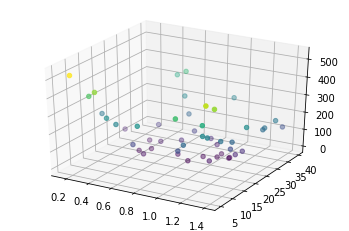

In [272]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
zdata = Y_data[:,0]
xdata = Xsc[:,0]
ydata = Xsc[:,1]
ax.scatter3D(xdata, ydata, zdata, c=zdata);


In [273]:
def gaintheprediction(num1 = 5,num2 = 2): #get the prediction set num1 is the amount of alfa,num2 is the amoubt of vel
    x_alfa = np.array([np.linspace(0.15, 1.5, num1)])
    x_vel = np.array([np.linspace(5, 40, num2)])
    X_ = []
    for i in range(num1):
        for j in range(num2):
            X_.append([x_alfa[0,i],x_vel[0,j]])
    X_ =np.array(X_)
    return X_

In [285]:
X_ = gaintheprediction(10,10)
X_

array([[ 0.15      ,  5.        ],
       [ 0.15      ,  8.88888889],
       [ 0.15      , 12.77777778],
       [ 0.15      , 16.66666667],
       [ 0.15      , 20.55555556],
       [ 0.15      , 24.44444444],
       [ 0.15      , 28.33333333],
       [ 0.15      , 32.22222222],
       [ 0.15      , 36.11111111],
       [ 0.15      , 40.        ],
       [ 0.3       ,  5.        ],
       [ 0.3       ,  8.88888889],
       [ 0.3       , 12.77777778],
       [ 0.3       , 16.66666667],
       [ 0.3       , 20.55555556],
       [ 0.3       , 24.44444444],
       [ 0.3       , 28.33333333],
       [ 0.3       , 32.22222222],
       [ 0.3       , 36.11111111],
       [ 0.3       , 40.        ],
       [ 0.45      ,  5.        ],
       [ 0.45      ,  8.88888889],
       [ 0.45      , 12.77777778],
       [ 0.45      , 16.66666667],
       [ 0.45      , 20.55555556],
       [ 0.45      , 24.44444444],
       [ 0.45      , 28.33333333],
       [ 0.45      , 32.22222222],
       [ 0.45      ,

In [286]:
#the result before optimizing
p = RBF_Kernel()
p.set_hyperparameters([np.random.rand(),np.random.rand(),np.random.rand()],True, log=False)

parameter_before = p.get_hyperparameters()
print("likelihood",p.calculate_likelihood(Xsc,Y_data))
print("par before optimization",parameter_before)
xpre = X_
a,b = predict_output(xpre, Xsc, Y_data, p)

likelihood [[493.42106732]]
par before optimization [-0.47607663 -0.05316136 -1.09121133]


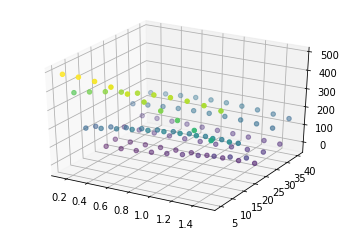

In [292]:
ax = plt.axes(projection='3d')

zdata = a
xdata = X_[:,0]
ydata = X_[:,1]
ax.scatter3D(xdata, ydata, zdata, c=zdata);

In [291]:
np.min(a),X_[np.argmin(a)]

(-22.79925307819849, array([ 0.15      , 20.55555556]))

In [136]:
#the result after optimizing
opt =  optimize_kernel_hyperparameters(p,X_data,Y_data[:,0])
parameter_after = opt.get_hyperparameters()
print("par after",parameter_after)
print("likelihood after opt",p.calculate_likelihood(Xsc,Y_data))
xpre = X_
c,d = predict_output(xpre, Xsc, Y_data, p)


optimization bounds: [[ -6   5]
 [ -6   5]
 [-12   0]]
par after [ 0.92921562  0.35285392 -7.17449935]
likelihood after opt [[499.58040943]]


In [137]:
X_[np.argmin(np.abs(c-0))]

array([ 1.5, 40. ])

In [138]:
np.min(np.abs(c-0))

0.01680299116030992

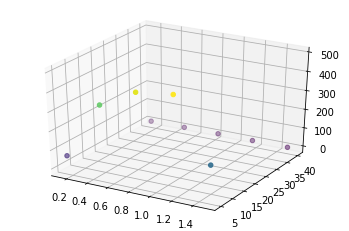

In [139]:
ax = plt.axes(projection='3d')
zdata = c
xdata = X_[:,0]
ydata = X_[:,1]
ax.scatter3D(xdata, ydata, zdata, c=zdata)

In [205]:
#acuquisition fuc type1
def type1acq(Xscl,Y,ker: RBF_Kernel,num1=2 ,num2 = 5):
    x_alfa = np.array([np.linspace(0.15, 1.5, num1)])
    x_vel = np.array([np.linspace(5, 40, num2)])
    X_ = []
    for i in range(num1):
        for j in range(num2):
            X_.append([x_alfa[0,i],x_vel[0,j]])
    X_ =np.array(X_)
    varset = np.empty(num1*num2)
    maxvar = 0
    for i in range(num1*num2):
        xnw  = np.array([X_[i]])
        u_avg,var = predict_output(xnw, Xscl, Y, ker) 
        varset[i] = var
        if(var > maxvar):
            maxvar = var
            idx = i
    ax = plt.axes(projection='3d')
    zdata = varset
    xdata = X_[:,0]
    ydata = X_[:,1]
    ax.scatter3D(xdata, ydata, zdata, c=zdata)         
    print(varset,'\n',"select",varset[idx],'\n',"next sample point",'\n',X_[idx])        
    return X_[idx]

[30865.8385861  21665.04844315 31589.3455413   1348.66829539
 31668.33204069 27300.95253119 31667.56453746 22592.82761678
 31607.63457947 31668.51219901] 
 select 31668.512199008786 
 next sample point 
 [ 1.5 40. ]


array([ 1.5, 40. ])

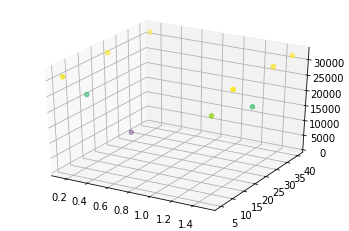

In [206]:
type1acq(Xsc,Y_data,p)

In [193]:

#acuquisition fuc type2
def type2acq(Xscl,Y,ker: RBF_Kernel,num1 = 2,num2 = 5):

    x_alfa = np.array([np.linspace(0, 1.5, num1)])
    x_vel = np.array([np.linspace(5, 40, num2)])
    X_ = []
    for i in range(num1):
        for j in range(num2):
            X_.append([x_alfa[0,i],x_vel[0,j]])
    X_ =np.array(X_)
    maxvar = 0
    EI = 0
    X_ =np.array(X_)
    varset = np.empty(num1*num2)
    muset = np.empty(num1*num2)
    pstd = np.empty(num1*num2)
    EI = np.empty(num1*num2)
    for i in range(num1*num2):
        xnw  = np.array([X_[i]])
        mu,var = predict_output(xnw, Xscl, Y, ker)  
        Y_min = np.amin(Y)
        pstd[i] = (Y_min - mu)/var
        varset[i] = var
        muset[i] = mu   
    for i in range(num1*num2):
        if(var == 0):
            EI[i] = 0
        else:
            EI[i] = (Y_min - muset[i])*norm.cdf(pstd[i])+varset[i]*norm.pdf(pstd[i])

    idx = np.argmax(EI) 
    print(EI,'\n',"select",EI[idx])   
    return X_[idx]

[12605.17599795  9379.46071574 12632.40993511  3783.8235521
 12633.87772259 10806.78613179 12633.36336492  8984.61631091
 12609.14123885 12633.99081183] 
 select 12633.990811830869


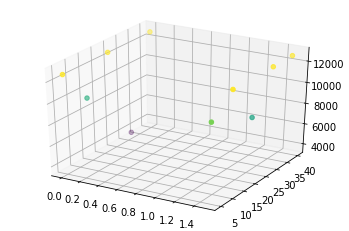

In [194]:
h,l = type2acq(Xsc,Y_data,p)

In [311]:
def main(n_doe_samples=30, maxiter_bayesopt=10):
    """
    This is the main function, where the main program steps need to be implemented
    """

    # set the interval of suitable (alpha, V_0) values
    alpha_max, alpha_min = 1.5, 0.15
    V_0_max, V_0_min = 40, 5
    
    # get input data (X,Y)
    X = get_doe_samples(n_doe_samples)
    X_scaled = scale_input(X, alpha_min, alpha_max, V_0_min, V_0_max)
    Y = evaluate(X_scaled)

    regularization = False          # boolean
    # "regularization" is a flag to indicate if we add a new hyparameter "sigma" in the slide 32 at Lecture 8. The result of the "regularization" True and False can be seen on the slide 33 and slide 30, respectively.
    # initialize the kernel and optimize its hyperparameters
    kernel = RBF_Kernel()

    ### Test an arbitrary theta ###
    """
    bounds_theta = np.array( [ [-6, 5],  [-6, 5] ] )
    bounds_reg   = np.array( [ [-12, 0] ] )
    """
    theta_test = [1.,2.]    # please input your 
    regPara_test = -1.    # You do not need to change this.
    if regularization:
        hyperparameter_test = theta_test + [regPara_test]
    else:
        hyperparameter_test = theta_test
    kernel.set_hyperparameters(hyperparameters=hyperparameter_test, regularization=regularization, log=False)         # a value from -6. to 5.
        ### Determine the hyperparameter theta by MLE ###
    kernel = optimize_kernel_hyperparameters(kernel, X_scaled, Y[:,0], regularization=True, maxiter=100, disp=True)
    print(kernel.calculate_likelihood(X_scaled,Y))
    Xpre = np.array([[0.5,17.]]) ##this is just for test 
    ypre, yvar = predict_output(Xpre, X_scaled, Y, kernel)
    print("ypre is",ypre)
    print("yvar is",yvar)
    
    # copy the DoE data for the optimization loop
    Xupdated = np.copy(X_scaled)
    Yupdated = np.copy(Y)

    # bayesian optimization loop
    for i in range(maxiter_bayesopt):

        print("BayesOpt Iter", i)
        """ 
        ### MESSAGE FOR STUDENTS ###
        ### Here you need to calculate the acquisition function 
        ### and find the next value by optimizing the input argument of the acquisition function 
        """

        Xnew = type2acq(Xupdated,Yupdated,kernel,5,2)
        Xnew = np.atleast_2d(Xnew)

        Ynew = evaluate(Xnew)

        Xupdated = np.vstack((Xupdated, Xnew))          # updated data X
        Yupdated = np.vstack((Yupdated, Ynew))          # updated data Y
        


    xpre = gaintheprediction(num1 = 10,num2 = 4)
    c,d = predict_output(xpre, Xupdated, Yupdated, kernel)
    print("the  target x ",xpre[np.argmin(np.abs(c-0))],"the y is",np.min(np.abs(c-0)))
    ax = plt.axes(projection='3d')
    zdata = c
    xdata = xpre[:,0]
    ydata = xpre[:,1]
    ax.scatter3D(xdata, ydata, zdata, c=zdata)

optimization bounds: [[ -6   5]
 [ -6   5]
 [-12   0]]
differential_evolution step 1: f(x)= 191.365
differential_evolution step 2: f(x)= 191.365
differential_evolution step 3: f(x)= 191.365
differential_evolution step 4: f(x)= 191.365
differential_evolution step 5: f(x)= 187.915
differential_evolution step 6: f(x)= 185.135
differential_evolution step 7: f(x)= 185.012
differential_evolution step 8: f(x)= 183.718
differential_evolution step 9: f(x)= 183.69
differential_evolution step 10: f(x)= 183.68
differential_evolution step 11: f(x)= 183.665
differential_evolution step 12: f(x)= 183.665
differential_evolution step 13: f(x)= 183.618
differential_evolution step 14: f(x)= 183.593
differential_evolution step 15: f(x)= 183.593
[[183.59179047]]
ypre is [54.50174711]
yvar is [0.40573833]
BayesOpt Iter 0
[1.45804961e+003 1.66636905e+003 2.63771952e-038 9.10876583e+002
 0.00000000e+000 3.14917187e+002 1.36758485e-127 9.22181405e+001
 2.11536834e+002 3.45094300e+002] 
 select 1666.369053577917

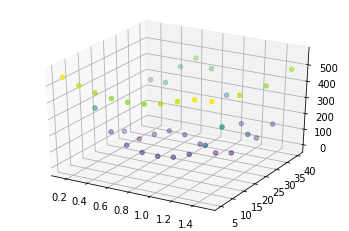

In [312]:
# this condition will be true, if you call this program as 'python exam_task1.py'
if __name__ == "__main__":

    # test and try to understand the simulator
    #test_simulator()  you can delete/comment this line, if you don't need it anymore

    # execute the main program
    main()